In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import osmnx as ox
import folium

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%pwd

'/home/cseadmin/dz/TrafficFlowModel/scripts'

In [2]:
taxi_data_path = os.walk("../data/taxi")
all_files = []
for root,ds,fs in taxi_data_path:
    days = []
    for f in fs:
        full_path = os.path.join(root, f)
        days.append(full_path)
    if len(days)==0:
        continue
    all_files.append(days)
    
all_files.sort()
for day in all_files:
    day.sort()
all_files[:2]

[['../data/taxi/202006/2020-06-01/2020-06-01_0',
  '../data/taxi/202006/2020-06-01/2020-06-01_1',
  '../data/taxi/202006/2020-06-01/2020-06-01_2',
  '../data/taxi/202006/2020-06-01/2020-06-01_3',
  '../data/taxi/202006/2020-06-01/2020-06-01_4',
  '../data/taxi/202006/2020-06-01/2020-06-01_5',
  '../data/taxi/202006/2020-06-01/2020-06-01_6',
  '../data/taxi/202006/2020-06-01/2020-06-01_7',
  '../data/taxi/202006/2020-06-01/2020-06-01_8',
  '../data/taxi/202006/2020-06-01/2020-06-01_9'],
 ['../data/taxi/202006/2020-06-02/2020-06-02_0',
  '../data/taxi/202006/2020-06-02/2020-06-02_1',
  '../data/taxi/202006/2020-06-02/2020-06-02_2',
  '../data/taxi/202006/2020-06-02/2020-06-02_3',
  '../data/taxi/202006/2020-06-02/2020-06-02_4',
  '../data/taxi/202006/2020-06-02/2020-06-02_5',
  '../data/taxi/202006/2020-06-02/2020-06-02_6',
  '../data/taxi/202006/2020-06-02/2020-06-02_7',
  '../data/taxi/202006/2020-06-02/2020-06-02_8',
  '../data/taxi/202006/2020-06-02/2020-06-02_9']]

In [3]:
names = [
    "sys_time", "license_number", "lng", "lat", "gps_time", "EMPTY1", "speed",
    "direction", "car_status", "alarm_status", "EMPTY2", "EMPTY3",
    "license_color", "recorder_speed", "mileage", "height", "EMPTY4"
]

file_0601=all_files[1]

df_0601=pd.DataFrame()
for taxi_file in file_0601:
    df_0601=df_0601.append(pd.read_csv(taxi_file, names=names)[["license_number", "gps_time", "lat", "lng", "speed"]])

print(len(df_0601))
df_0601

97453725


,license_number,gps_time,lat,lng,speed
0,粤BD77165,2020-06-01 23:59:49,22.610820,113.920950,61
1,粤B7ZY30,2000-01-01 00:00:00,0.000000,0.000000,0
2,粤BD02973,2020-06-01 23:59:50,22.726140,114.265140,0
3,粤B0NC67,2000-01-01 00:00:00,0.000000,0.000000,0
4,粤BDR7746,2020-06-01 23:59:48,22.569310,114.099100,58
...,...,...,...,...,...
7453720,粤BDA1040,2020-06-02 23:59:51,22.556341,113.980740,0
7453721,粤BV2N51,2000-01-01 00:00:00,0.000000,0.000000,0
7453722,粤BD98097,2020-06-02 23:59:48,22.617779,113.934586,65
7453723,粤BV1P31,2000-01-01 00:00:00,0.000000,0.000000,0


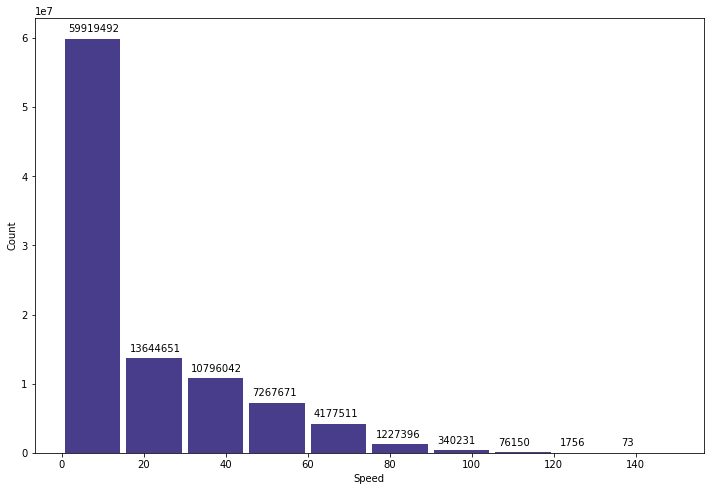

In [19]:
plt.figure(figsize=(12, 8))
plt.xlabel("Speed")
plt.ylabel("Count")
density, bins, _=plt.hist(df_0601.speed, bins=None, range=(0, 150), histtype="bar", rwidth=0.9, color="darkslateblue")
count, _ = np.histogram(df_0601.speed, bins)
for x, y, num in zip(bins, density, count):
    if num != 0:
        plt.text(x+1.5, y+1e6, num, fontsize=10) # x,y,str
plt.show();

In [18]:
SZ_MINLON = 113.751647
SZ_MAXLON = 114.622924
SZ_MINLAT = 22.400047
SZ_MAXLAT = 22.855425

df_0601_clean=df_0601.drop_duplicates()
df_0601_clean=df_0601_clean.loc[(df_0601_clean["lat"]>=SZ_MINLAT) & (df_0601_clean["lat"]<=SZ_MAXLAT) &
                    (df_0601_clean["lng"]>=SZ_MINLON) & (df_0601_clean["lng"]<=SZ_MAXLON) &
                    (df_0601_clean["gps_time"]>="2020-06-01") & (df_0601_clean["gps_time"]<"2020-06-02") &
                    (df_0601_clean["speed"]<150) & (df_0601_clean["speed"]>0)]

df_0601_clean

,license_number,gps_time,lat,lng,speed
0,粤BD77165,2020-06-01 23:59:49,22.610820,113.92095,61
4,粤BDR7746,2020-06-01 23:59:48,22.569310,114.09910,58
6,粤BDG2918,2020-06-01 23:59:49,22.570156,113.92883,66
8,粤BD47906,2020-06-01 23:59:51,22.583370,113.86624,18
10,粤BA31863,2020-06-01 23:59:48,22.547894,114.12541,39
...,...,...,...,...,...
7428428,粤BDD0757,2020-06-01 13:00:17,22.713800,114.31099,16
7428432,粤BDD0757,2020-06-01 13:00:22,22.713871,114.31091,9
7428436,粤BDD0757,2020-06-01 13:00:42,22.712784,114.31088,33
7440834,粤BDD0757,2020-06-01 13:01:51,22.711248,114.30961,22


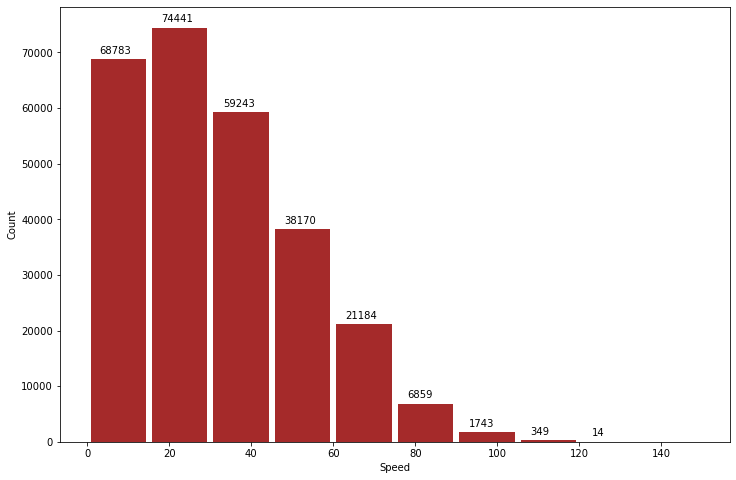

In [28]:
plt.figure(figsize=(12, 8))
plt.xlabel("Speed")
plt.ylabel("Count")
density, bins, _=plt.hist(df_0601_clean.speed, bins=None, range=(0, 150), histtype="bar", rwidth=0.9, color="brown")
count, _ = np.histogram(df_0601_clean.speed, bins)
for x, y, num in zip(bins, density, count):
    if num != 0:
        plt.text(x+3, y+1000, num, fontsize=10) # x,y,str
plt.show();